## [Lecture 8.4: Soft Margin SVM](https://www.youtube.com/watch?v=onOYSeX8idQ)

### Linear Support Vector Machines Classifier
In this notebook, we will implement linear SVM classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification, make_blobs

# set default color map for entire notebook/session
sns.set_theme(style="whitegrid")

### Model
- So far we trained a bunch of classifiers for learning a seperating hyperplane between classes. SVM also finds the separating hyperplanes between the classes - but with constraint the margin between classes maximized


- The hard margin SVM assumes that the classes are **linearly separable** and none of the data point is with the margin or is misclassified.

<img src="images/SVM.png" />

```python
np.sign(np.dot(w, x)+ b)
```

### Loss function 
We use **hinge loss** as a loss function: `max(0, 1 - t)
- It is equal to 0 when $t \ge 1$
- It's derivative (slope) is equal to -1 if $t \lt -1$ and 0 if $t \gt 1$
- It is not differentiable at t = 1

<img src="images/hinge_loss.png">

**Hinge Loss Function for SVM**:
$$
J(\mathbf{w}, b) = \frac{1}{2}||\mathbf{w}||^2 + C \sum_i \max (0, [1 - \mathbf{y}^{(i)}(\mathbf{w}^T\mathbf{x}^{i} + b)])
$$
The **second term** of the function, **hinge loss** is to penalize misclassifications
- It measures the error due to misclassification ( or data points being closer to the classification boundary than the margin)

"Hinge" describes the fact that  the error is 0 if the data point is classified correctly (and is not too close to  decision boundary).

We need to minimize the hinge loss function to find the max-margin classifier.

### Optimization procedure
We will be using gradient descent procedure for optimization.

### Soft SVM implementation

In [2]:
class softSVM:
    def __init__(self, C):
        self._support_vectors = None
        self.C = C
        self.w = None
        self.b = None
        self.X = None
        self.y = None

        # n is the number of data points
        self.n = 0

        # d is number of dimensions
        self.d = 0

    def _decision_function(self, X):
        return X.dot(self.w) + self.b

    def _cost(self, margin):
        return (1 / 2) * self.w.dot(self.w) + self.C + np.sum(
            np.maximum(0, 1- margin))
    
    def _margin(self, X, y):
        return y * self._decision_function(X)
    
    def fit(self, X, y, lr=1e-3, epochs= 500):

        # Initialize w and b
        self.n, self.d = X.shape
        self.w = np.random.randn(self.d)
        self.b = 0

        # Required only for plotting
        self.X = X
        self.y = y

        loss_array = []
        for _ in range(epochs):
            margin = self._margin(X, y)
            loss = self._cost(margin)
            loss_array.append(loss)

            misclassified_pts_idx = np.where(margin < 1)[0]
            d_w = self.w - self.C * y[misclassified_pts_idx].dot(X[misclassified_pts_idx])
            self.w = self.w - lr * d_w

            d_b = -self.C * np.sum(y[misclassified_pts_idx])
            self.b = self.b - lr * d_b

        self._support_vectors = np.where(
            self._margin(X, y) <= 1)[0]
    
    def predict(self, X):
        return np.sign(self._decision_function(X))
    
    def score(self, X, y):
        P = self.predict(X)
        return np.mean(y == P)
    
    def plot_decision_boundary(self):
        plt.scatter(self.X[:,0], self.X[:,1], c = self.y, marker='o',
                    s=100, cmap='autumn')
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid  to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)

        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)


        # plot decision boundary and margins

        ax.contour(XX, YY, Z, colors=['g', 'k', 'g'], levels=[-1, 0, 1],
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])
        
        # highlight the support vectors
        ax.scatter(self.X[:, 0][self._support_vectors],
                   self.X[:, 1][self._support_vectors], s=250,
                   linewidth=1, facecolors='none', edgecolors='k')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()

### Training Data
Let's first generate synthetic training data with two classes.

### Demo 1: Linearly separable data

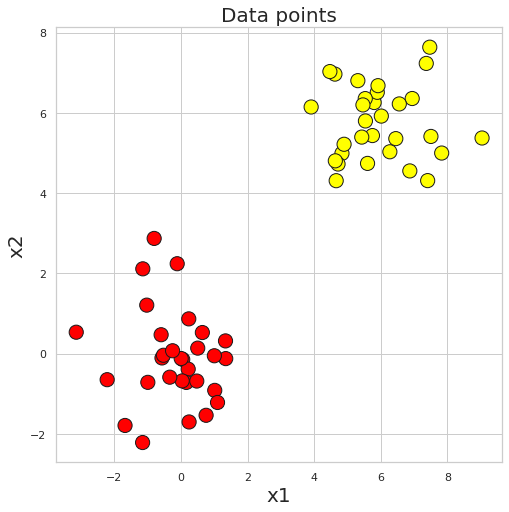

In [3]:
# generate artificial data points
X, Y = make_blobs(n_samples=60,
                  n_features=2,
                  centers=[[0,0], [6,6]],
                  cluster_std=1,
                  random_state=12)

Y = np.where(Y == 0 , -1, 1)

# plot two classes
plt.figure(figsize=(8,8))

plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, s=200, edgecolor='k', cmap='autumn')
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.title('Data points', fontsize=20)
plt.show()

[0.36943542 0.20408022]


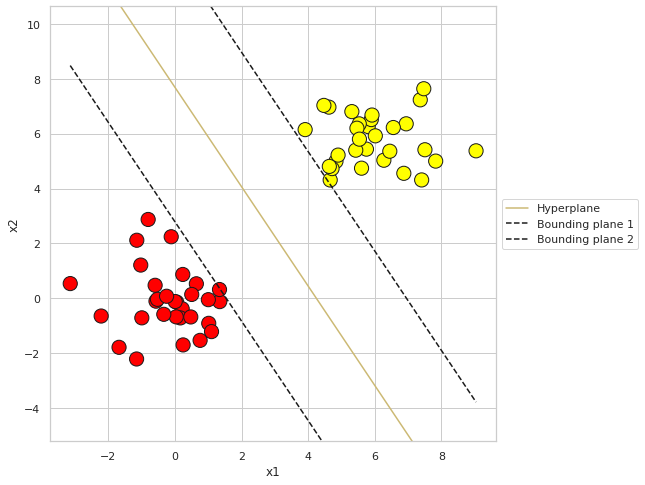

In [4]:
svm = softSVM(C=1)
svm.fit(X, Y)

print(svm.w)

def get_hyperplane_value(x, w, b, offset):
    return -(w[0] * x + b + offset)/w[1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, s=200, edgecolor='k', cmap='autumn')
x0_1 = np.amin(X[:, 0])
x0_2 = np.amax(X[:, 0])

x1_1 = get_hyperplane_value(x0_1, svm.w, svm.b, 0)
x1_2 = get_hyperplane_value(x0_2, svm.w, svm.b, 0)

x1_1_m = get_hyperplane_value(x0_1, svm.w, svm.b, -1)
x1_2_m = get_hyperplane_value(x0_2, svm.w, svm.b, -1)

x1_1_p = get_hyperplane_value(x0_1, svm.w, svm.b, 1)
x1_2_p = get_hyperplane_value(x0_2, svm.w, svm.b, 1)

ax.plot([x0_1, x0_2], [x1_1, x1_2], "y",label='Hyperplane')
ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k--",label='Bounding plane 1')
ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k--", label='Bounding plane 2')

x1_min = np.amin(X[:, 1])
x1_max = np.amax(X[:, 1])

ax.set_ylim([x1_min -3, x1_max + 3])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


### Prediction of new example

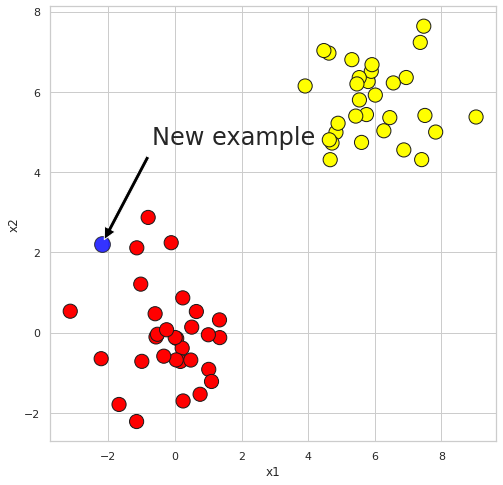

In [5]:
newExample = np.array([-2.2, 2.2])

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, s=200, edgecolor='k', cmap='autumn')

plt.scatter(newExample[0], newExample[1], marker='o', c='blue', s=250,edgecolor='k', alpha=0.8)
plt.annotate('New example', xy=newExample,
             xytext=(50, 100), textcoords='offset points',
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=24)

plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [6]:
svm.predict(newExample)

-1.0

### Demo 2: Linearly separable with noise

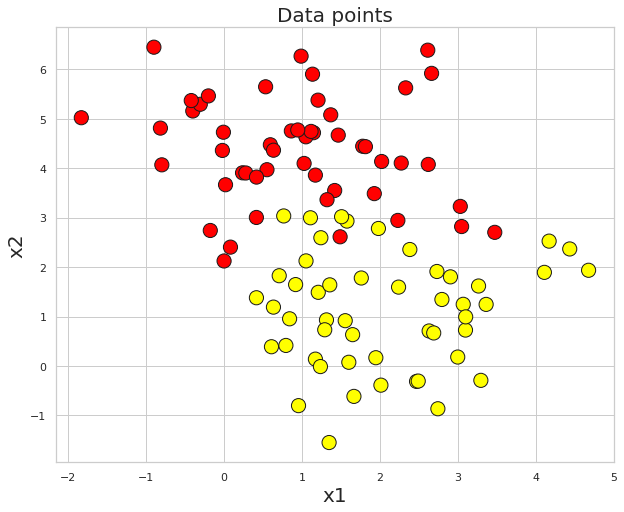

In [7]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs
import seaborn as sns

# set default color map for the entire notebook
sns.set_theme(style='whitegrid')

X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.1)

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=200, edgecolor='k', cmap='autumn')
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.title('Data points', fontsize=20)
plt.show()

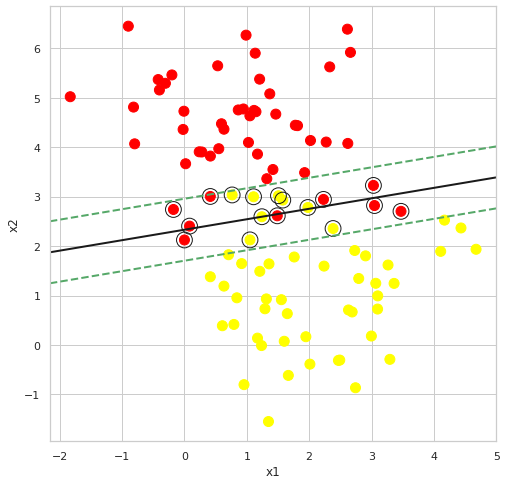

In [8]:
y[y == 0 ] = -1
svm = softSVM(C=10)
svm.fit(X, y)

fig = plt.figure(figsize=(8,8))
svm.plot_decision_boundary()

### Demo 3: Linearly non-separable data

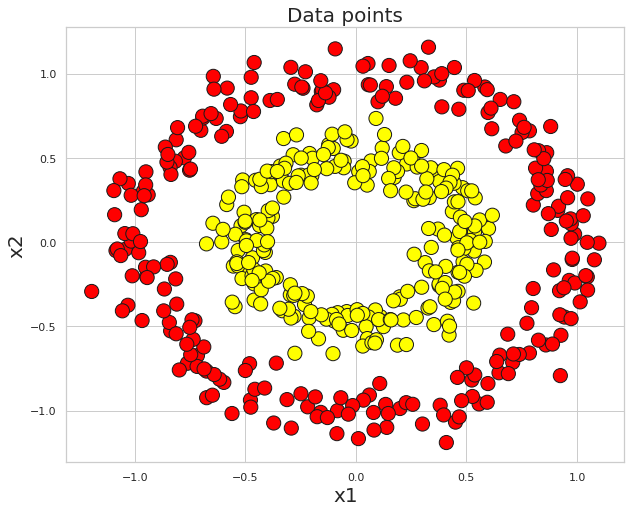

In [9]:
from sklearn.datasets import make_circles
X, y = make_circles(500, factor=0.5, noise=0.08)
y[y == 0] = -1

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=200, edgecolor='k', cmap='autumn')
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.title('Data points', fontsize=20)
plt.show()

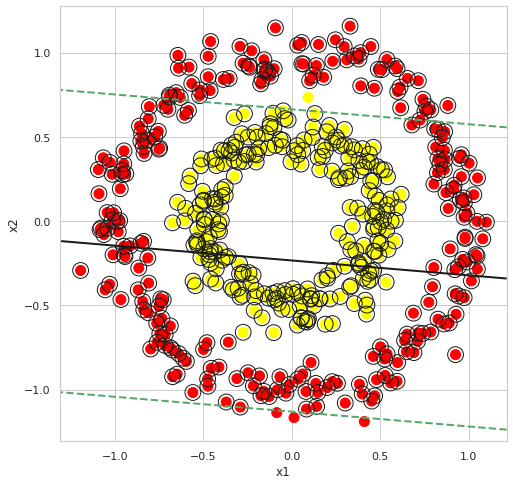

In [10]:
y[y == 0 ] = -1
svm = softSVM(C=10)
svm.fit(X, y)

fig = plt.figure(figsize=(8,8))
svm.plot_decision_boundary()

## [Lecture 8.5: Kernel SVM](https://www.youtube.com/watch?v=eUlBWyazbuk)

### Kernel SVM
We will be implementing dual problem of soft SVM by replacing the dot product between the two feature vectors with kernel function.

The similarity of two points is calculated with a specific kernel function.

From $\mathcal{L}_p$, the (Wolfe) dual for soft SVM is as follows:
$$
\begin{align}
    \mathcal{L}_d(\alpha) &= \sum_{i=1}^n \alpha^{(i)} - \frac{1}{2} \sum_{i=i}^n \sum_{k=1}^n \alpha^{(i)} \alpha^{(k)} \mathbf{y}^{(i)} \mathbf{y}^{(k)} \mathbf{x}^{(i)^T} \mathbf{x}^{(k)} \\
    &= \sum_{i=1}^n \alpha^{(i)} - \frac{1}{2} \sum_{i=i}^n \sum_{k=1}^n \langle \alpha^{(i)}\mathbf{y}^{(i)}\mathbf{x}^{(i)} , \alpha^{(k)}\mathbf{y}^{(k)}\mathbf{x}^{(k)}\rangle
\end{align}
$$
**Subject to** $\forall i \in 1...n$ :
- $0 \le \alpha^{(i)} \le C$
- $\sum_{i=1}^n \alpha^{(i)}\mathbf{y}^{(i)} = 0$

It is a concave problem that is maximized using a solver.

In [11]:
class SVMDualProblem:
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = 1
            self.degree = degree
        else:
            self.kernel = self._rbf_kernel
            self.sigma = sigma
        
        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None
    
    def _rbf_kernel(self, X1, X2):
        return np.exp(-(1/self.sigma**2) * np.linalg.norm(
            X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)
    
    def _polynomial_kernel(self, X1, X2):
        return (self.c + X1.dot(X2.T)) ** self.degree
    
    def fit(self, X, y, lr=1e-3, epochs=100):
        self.X = X
        self.y = y

        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0])

        y_iy_k_ij = np.outer(y, y) * self.kernel(X, X)
        losses = []
        for _ in range(epochs):
            gradient = self.ones - y_iy_k_ij.dot(self.alpha)

            self.alpha = self.alpha + lr * gradient

            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            loss = np.sum(self.alpha) - 0.5 * np.sum(
                np.outer(self.alpha, self.alpha) * y_iy_k_ij)
            
            losses.append(loss)
        
        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))

        self.b = np.mean(b_i)
        
        plt.plot(losses)
        plt.title('Loss per epochs')
        plt.show()
    
    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        return np.sign(self._decision_function(X))
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    
    def plot_decision_boundary(self):
        plt.scatter(self.X[:,0], self.X[:,1], c = self.y, marker='o',
                    s=50, cmap=plt.cm.Paired, alpha=0.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid  to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)

        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)


        # plot decision boundary and margins

        ax.contour(XX, YY, Z, colors=['g', 'k', 'g'], levels=[-1, 0, 1],
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])
        
        # highlight the support vectors
        ax.scatter(self.X[:, 0][self.alpha > 0],
                   self.X[:, 1][self.alpha > 0], s=50,
                   linewidth=1, facecolors='none', edgecolors='k')
        plt.show()

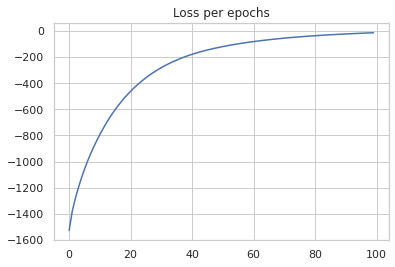

train score: 1.0


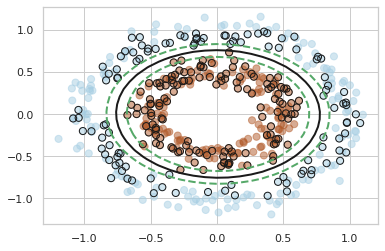

In [12]:
svm = SVMDualProblem(C=1.0, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print('train score:', svm.score(X, y))
svm.plot_decision_boundary()

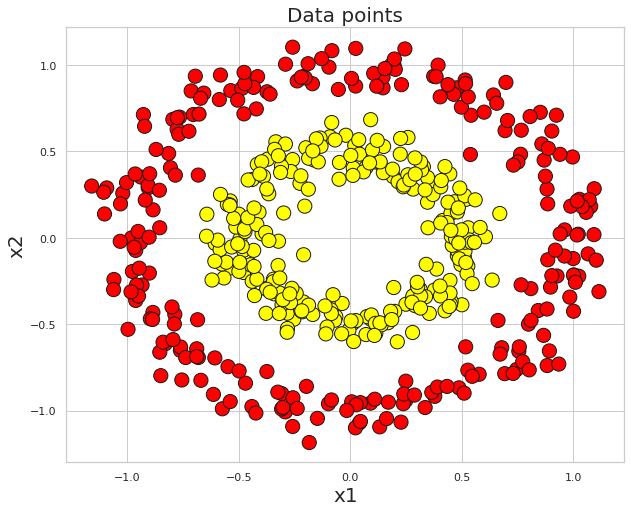

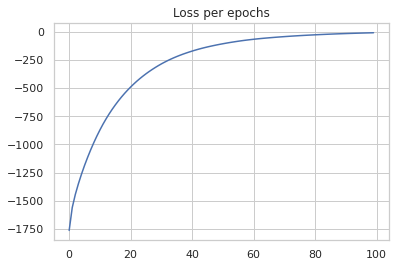

train score: 0.996


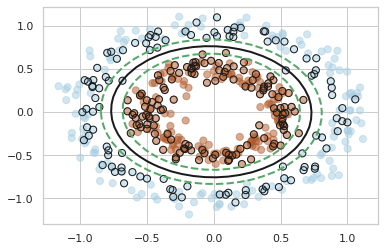

In [13]:
from sklearn.datasets import make_circles
X, y = make_circles(500, factor=0.5, noise=0.08)
y[y == 0] = -1

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=200, edgecolor='k', cmap='autumn')
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.title('Data points', fontsize=20)
plt.show()

svm = SVMDualProblem(C=1.0, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print('train score:', svm.score(X, y))
svm.plot_decision_boundary()